# WSI zadanie 6

Artur Kempiński

Oliwier Szypczyn

Użyta technologia:

python==3.11.6

matplotlib==3.8.0

scikit-learn==1.3.2

numpy==1.24.3

pandas==2.0.3

In [1]:
import pandas as pd
import glob
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split as tts
import numpy as np
from sklearn.metrics import roc_curve, accuracy_score, classification_report, roc_auc_score, auc
from matplotlib import pyplot as plt
import random
from sklearn.preprocessing import label_binarize

# Przygotowywanie i formatowanie danych

In [2]:
def prepare_data(path : str, random_state=random.randint(1, 10000)) -> tuple:
    files = glob.glob(f'{path}/data-*')
    scaler = MinMaxScaler()
    aggregated_data = pd.DataFrame()

    for file in files:
        current_data = pd.read_csv(file, delimiter='\t', header=None, names=['Date', 'Time', 'Type', 'Insulin'])
        aggregated_data = pd.concat([aggregated_data, current_data])

    aggregated_data = aggregated_data[['Date', 'Time', 'Insulin', 'Type']]

    columns_to_normalize = ['Insulin', 'Time', 'Date']
    aggregated_data['Insulin'] = aggregated_data['Insulin'].replace(["0Hi", "0Lo", "0''"], 0.0)
    aggregated_data['Time'] = pd.to_datetime(aggregated_data['Time'], format='%H:%M', errors='coerce').dt.time
    aggregated_data['Time'] = aggregated_data['Time'].apply(lambda x: x.hour * 60 + x.minute)
    aggregated_data['Date'] = pd.to_datetime(aggregated_data['Date'], format='%m-%d-%Y', errors='coerce')
    aggregated_data['Date'] = aggregated_data['Date'].dt.dayofyear
    aggregated_data = aggregated_data.dropna()

    aggregated_data[columns_to_normalize] = scaler.fit_transform(aggregated_data[columns_to_normalize])

    aggregated_data = pd.get_dummies(aggregated_data, columns=['Type'], dtype=int)

    aggregated_data.to_csv('normalized_data.csv', index=False)

    features = aggregated_data[['Date', 'Time', 'Insulin']].to_numpy()
    headers = aggregated_data.columns.values.tolist()
    labels = aggregated_data[[col for col in headers if col.startswith('Type')]].to_numpy()

    features_train, features_test, labels_train, labels_test = tts(features, labels, test_size=0.2, random_state=random_state)

    result = []
    for dataset in (features_train, features_test, labels_train, labels_test):
        temp = []
        for row in dataset:
            temp.append([row])
        result.append(np.array(temp))

    return tuple(result)

# Implementacja

In [3]:
class Network:
    def __init__(self):
        self.layers = []
        self.loss = self._mse
        self.loss_prime = self._mse_prime

    def add(self, layer):
        self.layers.append(layer)

    def predict(self, input_data):
        samples = len(input_data)
        result = []

        for i in range(samples):
            output = self._propagate_layers_forward(input_data[i])
            result.append(output)

        return result

    def fit(self, x_train, y_train, epochs, learning_rate, draw_plot=False, print_epoch=False):
        samples = len(x_train)
        data = []
        for i in range(epochs):
            err = 0
            for j in range(samples):
                output = self._propagate_layers_forward(x_train[j])

                err += self.loss(y_train[j], output)

                error = self.loss_prime(y_train[j], output)
                self._propagate_layers_backward(error, learning_rate)

            err /= samples
            data.append(err)

            if print_epoch:
                print(f'epoch {i+1}/{epochs}\terror={err}')

        if draw_plot:
            plt.plot(data)
            plt.show()

    def _propagate_layers_forward(self, input_data):
        output = input_data
        for layer in self.layers:
            output = layer.forward_propagation(output)
        return output

    def _propagate_layers_backward(self, error, learning_rate):
        for layer in reversed(self.layers):
            error = layer.backward_propagation(error, learning_rate)

    def _mse(self, y_true, y_pred):
        return np.mean(np.power(y_true - y_pred, 2))

    def _mse_prime(self, y_true, y_pred):
        return 2 * (y_pred - y_true) / np.size(y_true)


In [4]:
class Layer:
    def __init__(self, input_size, output_size, activation_f_type = 'sigmoid'):
        self.weights = np.random.uniform(low=-1/np.sqrt(input_size), high=1/np.sqrt(input_size), size=(input_size, output_size))
        self.bias = np.random.rand(1, output_size) - 0.5
        self.activation, self.activation_prime = self._get_activation_f(activation_f_type)

    def forward_propagation(self, input_data):
        self.input = input_data
        self.output = np.dot(self.input, self.weights) + self.bias
        return self.activation(self.output)

    def backward_propagation(self, output_error, learning_rate):
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error

        return self.activation_prime(self.input) * input_error

    def _get_activation_f(self, activation_f_type):
        if activation_f_type == 'sigmoid':
            return self._sigmoid, self._sigmoid_prime
        elif activation_f_type == 'tanh':
            return self._tanh, self._tanh_prime
        elif activation_f_type == 'relu':
            return self._relu, self._relu_prime
        else:
            raise Exception('Activation function not supported')

    def _relu(self, x):
        return np.maximum(0, x)

    def _relu_prime(self, x):
        return np.where(x > 0, 1, 0)

    def _sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def _sigmoid_prime(self, x):
        return x * (1 - x)

    def _tanh(self, x):
        return np.tanh(x)

    def _tanh_prime(self, x):
        return 1 - x * x

In [5]:
def parse_result(result):
    data_codes = [4, 33, 34, 35, 36, 48, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]
    output = []
    for row in result:
        output.append(data_codes[np.argmax(row)])
    return np.array(output)

# Analiza

In [6]:
x_train, x_test, y_train, y_test = prepare_data('Diabetes-Data')

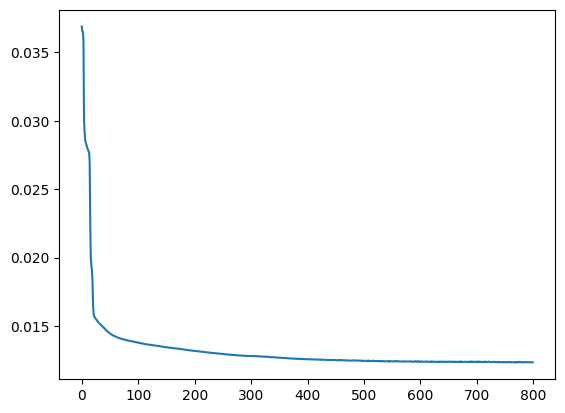

0.8031105793881388


In [21]:
net = Network()
net.add(Layer(3, 10, 'sigmoid'))
net.add(Layer(10, 15, 'sigmoid'))
net.add(Layer(15, 10, 'sigmoid'))
net.add(Layer(10, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=800, learning_rate=0.2, draw_plot=True)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

Pierwszy wykres służy odnalezieniu dobrej liczby epok do dalszego trenowania.

Zdecydowaliśmy, że 200 epok będzie wystarczające aby osiągnać dobre wyniki w rozsądnym czasie

Poniżej przeanalizowaliśmy kilka wybranych struktur sieci, do dalszych testów wybraliśmy wariant drugi

In [23]:
net = Network()
net.add(Layer(3, 10, 'sigmoid'))
net.add(Layer(10, 15, 'sigmoid'))
net.add(Layer(15, 10, 'sigmoid'))
net.add(Layer(10, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

0.78260126474107


In [24]:
net = Network()
net.add(Layer(3, 7, 'sigmoid'))
net.add(Layer(7, 15, 'sigmoid'))
net.add(Layer(15, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

0.794735942573919


In [26]:
net = Network()
net.add(Layer(3, 10, 'sigmoid'))
net.add(Layer(10, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

0.7680738335327294


Z wykorzystaniem poprzednio wybranej struktury sieci przetestowaliśmy róźne funkcje aktywacji

In [27]:
net = Network()
net.add(Layer(3, 7, 'sigmoid'))
net.add(Layer(7, 15, 'sigmoid'))
net.add(Layer(15, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

0.8017432917450008


In [28]:
net = Network()
net.add(Layer(3, 7, 'relu'))
net.add(Layer(7, 15, 'relu'))
net.add(Layer(15, 23, 'relu'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

Accuracy:  0.7795248675440096


In [29]:
net = Network()
net.add(Layer(3, 7, 'tanh'))
net.add(Layer(7, 15, 'tanh'))
net.add(Layer(15, 23, 'tanh'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)
print('Accuracy: ', accuracy_score(parse_result(y_test), parse_result(prediction)))

Accuracy:  0.775593915569988


# Analiza metryk dla pojedynczego treningu

In [9]:
x_train, x_test, y_train, y_test = prepare_data('Diabetes-Data', random_state=42)
net = Network()
net.add(Layer(3, 7, 'sigmoid'))
net.add(Layer(7, 15, 'sigmoid'))
net.add(Layer(15, 23, 'sigmoid'))
net.fit(x_train, y_train, epochs=200, learning_rate=0.2)
prediction = net.predict(x_test)

              precision    recall  f1-score   support

          33       0.78      0.95      0.86      1926
          34       0.66      0.64      0.65       738
          35       0.50      0.01      0.02       220
          48       0.68      0.96      0.80       353
          56       0.00      0.00      0.00        27
          57       0.48      0.07      0.12       214
          58       0.91      0.98      0.94       718
          59       0.00      0.00      0.00         2
          60       0.92      0.99      0.96       544
          61       0.67      0.12      0.21        16
          62       0.86      0.97      0.91       614
          63       0.25      0.02      0.04        47
          64       0.55      0.34      0.42       179
          65       0.45      0.08      0.14        59
          66       0.88      0.19      0.31        37
          67       0.57      0.35      0.44        68
          68       0.00      0.00      0.00         3
          69       0.00    

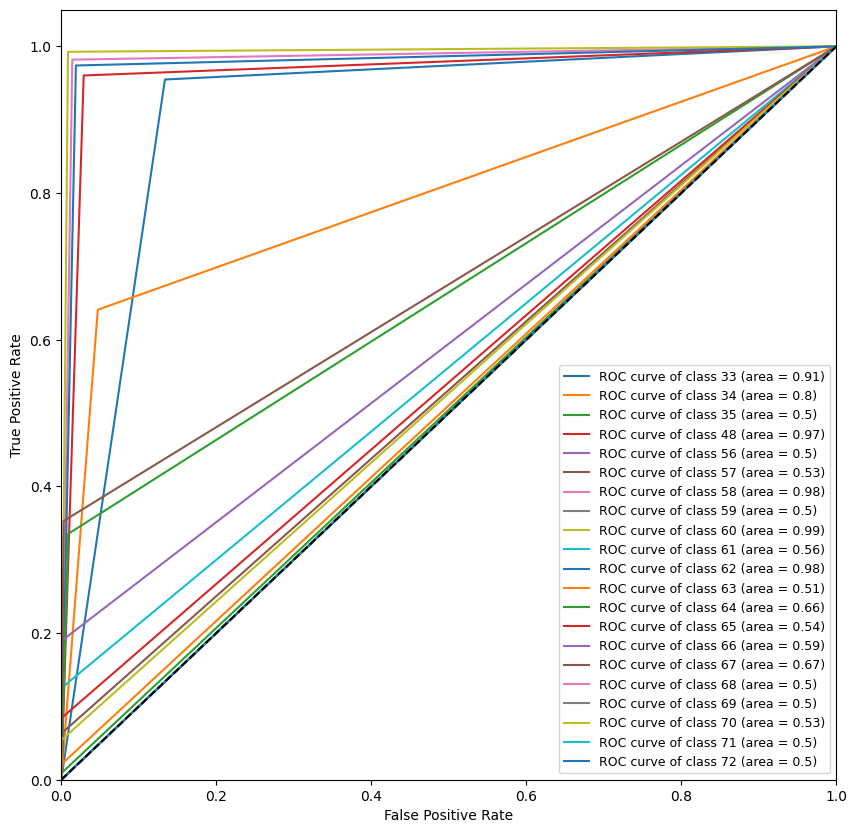

In [10]:
prediction = net.predict(x_test)
y1 = parse_result(y_test)
y2 = parse_result(prediction)
report = classification_report(y1, y2, zero_division=0)
print(report)

y1_bin = label_binarize(y1, classes=np.unique(y1))
y2_bin = label_binarize(y2, classes=np.unique(y1))
roc_auc = roc_auc_score(y1_bin, y2_bin, average='macro', multi_class='ovr')
print('One-vs-Rest ROC AUC avg score:', roc_auc)

n_classes = y1_bin.shape[1]
unique_classes = np.unique(y1)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y1_bin[:, i], y2_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 10))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {unique_classes[i]} (area = {round(roc_auc[i], 2)})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right", prop={'size': 9})
plt.show()

Przy analizowaniu wyników dla wybranej sieci neuronowej okazało się, że metryki preccision i recall zależą od ilości danych klas w zbiorze - świadczy o tym wyższa wartość ważnona niż uśredniona. Klasy które wystąpiły większą liczbę razy miały lepsze wyniki (np klasa 33, 34, 58, 60, 62). Ważona precyzja, czułość i dokładność wahają się na poziomie około 80% co jest całkiem dobrym wynikiem biorąc pod uwagę liczbę klas oraz sporą liczbę próbek. 

# Analiza hiperparametru szybkości uczenia

In [11]:
def draw_plots():
    x_train, x_test, y_train, y_test = prepare_data('Diabetes-Data', random_state=42)
    alfa = np.linspace(0.001, 1.2, 30)
    avg_accuracy = []
    avg_precision = []
    weighted_precision = []
    avg_recall = []
    weighted_recall = []

    for i, a in enumerate(alfa):
        print(f'Progress {(i+1) / len(alfa) * 100}%')
        net = Network()
        net.add(Layer(3, 7, 'sigmoid'))
        net.add(Layer(7, 15, 'sigmoid'))
        net.add(Layer(15, 23, 'sigmoid'))
        net.fit(x_train, y_train, epochs=200, learning_rate=a)
        prediction = net.predict(x_test)
        y1 = parse_result(y_test)
        y2 = parse_result(prediction)
        report = classification_report(y1, y2, zero_division=0, output_dict=True)
        avg_accuracy.append(report['accuracy'])
        avg_precision.append(report['macro avg']['precision'])
        weighted_precision.append(report['weighted avg']['precision'])
        avg_recall.append(report['macro avg']['recall'])
        weighted_recall.append(report['weighted avg']['recall'])

    fig, axs = plt.subplots(1, 3, figsize=(18, 6))

    plt.style.use('ggplot')

    axs[0].plot(alfa, avg_accuracy, marker='o', linestyle='-', color='b', label='Average Accuracy')
    axs[0].set_title('Accuracy', fontsize=16)
    axs[0].set_xlabel('Learning Rate', fontsize=14)
    axs[0].legend(fontsize=12)
    axs[0].grid(True)

    axs[1].plot(alfa, avg_precision, marker='o', linestyle='-', color='g', label='Average Precision')
    axs[1].plot(alfa, weighted_precision, marker='o', linestyle='-', color='r', label='Weighted Precision')
    axs[1].set_title('Precision', fontsize=16)
    axs[1].set_xlabel('Learning Rate', fontsize=14)
    axs[1].legend(fontsize=12)
    axs[1].grid(True)

    axs[2].plot(alfa, avg_recall, marker='o', linestyle='-', color='g', label='Average Recall')
    axs[2].plot(alfa, weighted_recall, marker='o', linestyle='-', color='r', label='Weighted Recall')
    axs[2].set_title('Recall', fontsize=16)
    axs[2].set_xlabel('Learning Rate', fontsize=14)
    axs[2].legend(fontsize=12)
    axs[2].grid(True)

    plt.tight_layout()
    plt.show()


Progress 3.3333333333333335%
Progress 6.666666666666667%
Progress 10.0%
Progress 13.333333333333334%
Progress 16.666666666666664%
Progress 20.0%
Progress 23.333333333333332%
Progress 26.666666666666668%
Progress 30.0%
Progress 33.33333333333333%
Progress 36.666666666666664%
Progress 40.0%
Progress 43.333333333333336%
Progress 46.666666666666664%
Progress 50.0%
Progress 53.333333333333336%
Progress 56.666666666666664%
Progress 60.0%
Progress 63.33333333333333%
Progress 66.66666666666666%
Progress 70.0%
Progress 73.33333333333333%
Progress 76.66666666666667%
Progress 80.0%
Progress 83.33333333333334%
Progress 86.66666666666667%
Progress 90.0%
Progress 93.33333333333333%
Progress 96.66666666666667%
Progress 100.0%


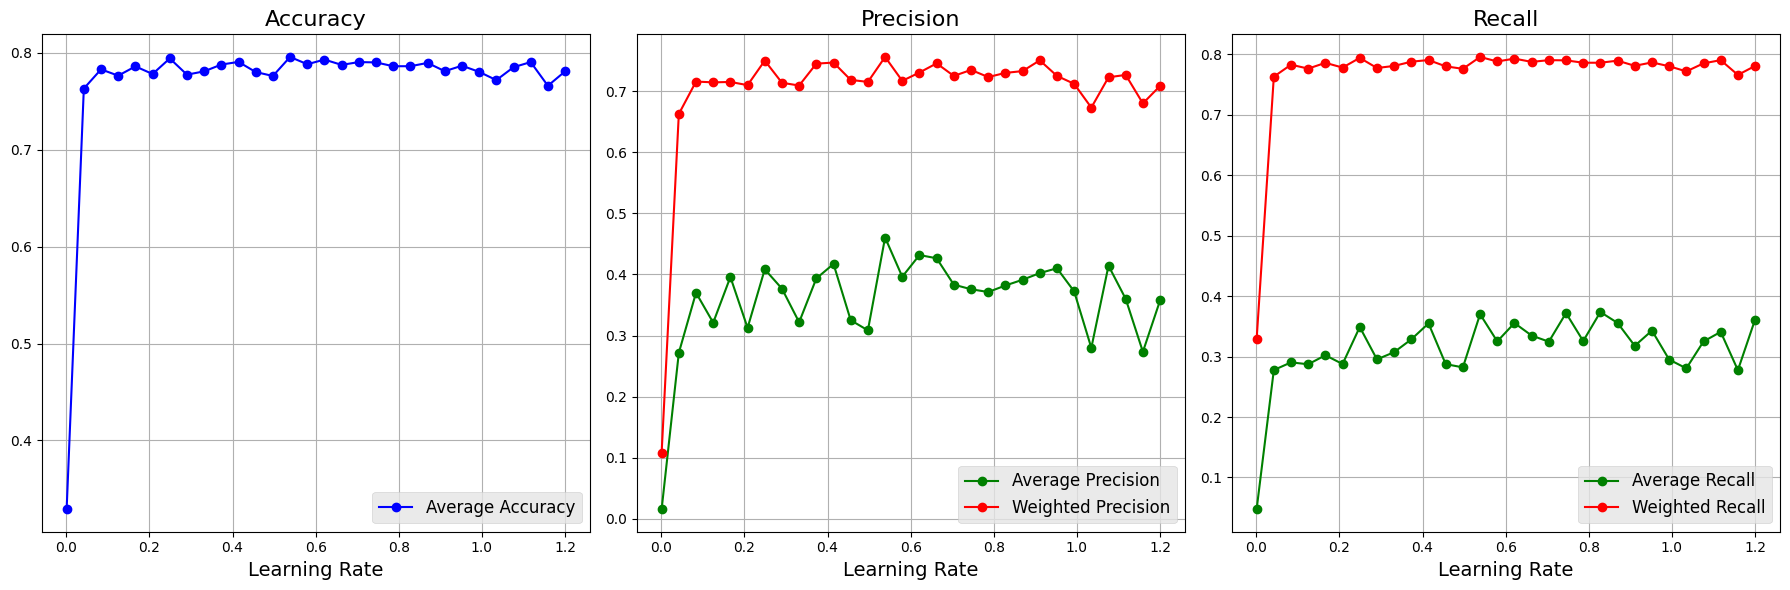

In [12]:
draw_plots()

Jak można zauważyć, bardzo niski learning rate dla zadanych 200 epok na trening ma negatywny wpływ na metryki, a więc jakość uczenia.

Dla learning rate ~0.05 metryki osiągają swoje maksimum, a dalsze zwiększanie go wydaje się nie mieć wiekszego wpływu na jakość uczenia się tego modelu.